### CM1 simulations combined analysis 

In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# aggregation indices
os.chdir('/data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA

In [4]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    y_avg[-window_N:] = y[-window_N:]
    y_avg[:window_N] = y[:window_N]
    return y_avg    

In [9]:
def read_data(data_dir,t_start=0,t_end=720):
    
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    
    u3d = data_3d.uinterp[t_start:t_end,:,:,:]
    v3d = data_3d.vinterp[t_start:t_end,:,:,:]
    w3d = data_3d.winterp[t_start:t_end,:,:,:]
    th3d = data_3d.th[t_start:t_end,:,:,:]
    qv3d = data_3d.qv[t_start:t_end,:,:,:]
    
    # zonal mean data
    th = data_zon.th[t_start:t_end,:,:,:]
    qv = data_zon.qv[t_start:t_end,:,:,:]
    qc = data_zon.qc[t_start:t_end,:,:,:]
    qi = data_zon.qi[t_start:t_end,:,:,:]
    prs = data_zon.prs[t_start:t_end,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:t_end,:,:]
    pwat = data_2d.pwat[t_start:t_end,:,:]
    cwp = data_2d.cwp[t_start:t_end,:,:]
    cape = data_2d.cape[t_start:t_end,:,:]
    cin = data_2d.cin[t_start:t_end,:,:]
    
    # 3d q
    data_q3d = xr.open_dataset('cm1out_q3d.nc')
    qc3d = data_q3d.qc[t_start:t_end,:,:,:]
    qi3d = data_q3d.qi[t_start:t_end,:,:,:]
    
    # for prs 3d 
    prs_ref = prs[0,:,:,0].mean('lat').values
    prs_3d = np.tile(prs_ref,(len(u3d.time),len(u3d.lon),len(u3d.lat),1)).swapaxes(1,3)
    prs_3d_xr = xr.DataArray(prs_3d, coords=[prs.time,data_3d.lev,data_3d.lat,data_3d.lon],dims=['time','lev','lat','lon'])

    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    T3d = th3d/((1000*100/prs_3d_xr)**(287.15/1004))-273.15 # [degC]
    
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
    #div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
    #vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
#    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro,th3d,v3d,u3d)
    return (th,T,qv,qc3d,qi3d,rh,prate*3600*24,pwat*1000,cwp,u3d,v3d,w3d,cape,cin,prs,ro,T3d,qv3d)

In [10]:
# get weather or weather2 
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_RCEP_240x240_CTRL',
            'CM1_RAD4K_RCEP_240x240_lowU05',
            'CM1_RAD4K_RCEP_240x240_lowU07',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU12',
            'CM1_RAD4K_RCEP_240x240_lowU15',
            'CM1_RAD4K_RCEP_240x240_lowU05_UNI',
            'CM1_RAD4K_RCEP_240x240_lowU10_UNI',
            'CM1_RAD4K_RCEP_240x240_lowU15_UNI']
# exp_name = ['CM1_RAD4K_RCEP_240x240_CTRL',
#             'CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240',
#             'CM1_RAD4K_OPENMP_Midjet_RCEP_120x240',
#             'CM1_RAD4K_OPENMP_Highjet_RCEP_120x240']

#os.chdir(server + exp_name)
os.system('mkdir -p fig_sum') # create a figure archive
fig_dir = server+'fig_sum' 

In [11]:
exp_short = ['CTRL','U05','U07','U10','U12','U15','U05_UNI','U10_UNI','U15_UNI']
#exp_short = ['CTRL','Low-jet','Mid-jet','High-jet']
colors = ['k','r','g','b','m','darkred','r','b','darkred']
linestyles= ['-','-','-','-','-','-',':',':',':']

In [12]:
(th1,T1,qv1,qc1,qi1,rh1,prate1,pwat1,cwp1,u3d1,v3d1,w3d1,cape1,cin1,prs1,ro1,T3d1,qv3dd1) = read_data(server+exp_name[0],t_start=360)
(th2,T2,qv2,qc2,qi2,rh2,prate2,pwat2,cwp2,u3d2,v3d2,w3d2,cape2,cin2,prs2,ro2,T3d2,qv3dd2) = read_data(server+exp_name[1],t_start=360)
(th3,T3,qv3,qc3,qi3,rh3,prate3,pwat3,cwp3,u3d3,v3d3,w3d3,cape3,cin3,prs3,ro3,T3d3,qv3dd3) = read_data(server+exp_name[2],t_start=360)
(th4,T4,qv4,qc4,qi4,rh4,prate4,pwat4,cwp4,u3d4,v3d4,w3d4,cape4,cin4,prs4,ro4,T3d4,qv3dd4) = read_data(server+exp_name[3],t_start=360)
(th5,T5,qv5,qc5,qi5,rh5,prate5,pwat5,cwp5,u3d5,v3d5,w3d5,cape5,cin5,prs5,ro5,T3d5,qv3dd5) = read_data(server+exp_name[4],t_start=360)
(th6,T6,qv6,qc6,qi6,rh6,prate6,pwat6,cwp6,u3d6,v3d6,w3d6,cape6,cin6,prs6,ro6,T3d6,qv3dd6) = read_data(server+exp_name[5],t_start=360)
(th7,T7,qv7,qc7,qi7,rh7,prate7,pwat7,cwp7,u3d7,v3d7,w3d7,cape7,cin7,prs7,ro7,T3d7,qv3dd7) = read_data(server+exp_name[6],t_start=360)
(th8,T8,qv8,qc8,qi8,rh8,prate8,pwat8,cwp8,u3d8,v3d8,w3d8,cape8,cin8,prs8,ro8,T3d8,qv3dd8) = read_data(server+exp_name[7],t_start=360)
(th9,T9,qv9,qc9,qi9,rh9,prate9,pwat9,cwp9,u3d9,v3d9,w3d9,cape9,cin9,prs9,ro9,T3d9,qv3dd9) = read_data(server+exp_name[8],t_start=360)

/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_CTRL
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU05
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU07
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU10
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU12
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU15
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU05_UNI
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU10_UNI
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU15_UNI


### domain-averaged pwat, prec

In [ ]:
for n,pwat in enumerate([pwat1,pwat2,pwat3,pwat4,pwat5,pwat6,pwat7,pwat8,pwat9]):
    print(exp_short[n]+': '+str(pwat.mean().values))

In [ ]:
for n,prate in enumerate([prate1,prate2,prate3,prate4,prate5,prate6,prate7,prate8,prate9]):
    print(exp_short[n]+': '+str(prate.mean().values))

In [ ]:
z_dim = th2.lev
y_dim = th2.lat # [km]
x_dim = th2.lon # [km]
t_dim = np.arange(len(th2))/72 # [day]

In [ ]:
fig,ax = plt.subplots(6,4,figsize=(10,10))
t = -30

for n,pwat in enumerate([pwat1,pwat2,pwat3,pwat4,pwat5,pwat6]):
    for i in range(4):
        if n == 0:
            cf=ax[n,i].pcolormesh(pwat.lon,pwat.lat,pwat[t+6*i,:,:],cmap='jet',vmin=35,vmax=55)
            cc=ax[n,i].contour(pwat.lon,pwat.lat,pwat[t+6*i,:,:],levels=[46],colors=['k'],linewidths=1)
            ax[n,i].set_xlim([0,pwat.lon[-1]])
            ax[n,i].set_ylim([0,pwat.lat[-1]])
        else:     
            cf=ax[n,i].pcolormesh(pwat.lon,pwat.lat,pwat[t+6*i,:,:],cmap='jet',vmin=35,vmax=55)
            cc=ax[n,i].contour(pwat.lon,pwat.lat,pwat[t+6*i,:,:],levels=[46],colors=['k'],linewidths=1)
            cf.cmap.set_under('w')
            rect = Rectangle((0, 120), 480, 240, linewidth=1, edgecolor='red'
                             ,facecolor='greenyellow',alpha=0.2,zorder=1)
            # Add the patch to the Axes
            ax[n,i].add_patch(rect)
            ax[n,i].set_xlim([0,prate.lon[-1]])
            ax[n,i].set_ylim([0,prate.lat[-1]])
        ax[n,i].set_xticks([]);ax[n,i].set_yticks([])
    ax[n,0].set_ylabel(exp_short[n],fontsize=14,fontweight='bold')
#fig.savefig(fig_dir+'/snapshots_pwat_all.png',bbox_inches='tight',transparent=False)

In [ ]:
fig,ax = plt.subplots(6,4,figsize=(10,10))
t = -30

for n,prate in enumerate([prate1,prate2,prate3,prate4,prate5,prate6]):
    for i in range(4):
        if n == 0:
            cf=ax[n,i].pcolormesh(prate.lon,prate.lat,prate[t+6*i,:,:]/24,cmap='jet',vmin=1)
            ax[n,i].set_xlim([0,prate.lon[-1]])
            ax[n,i].set_ylim([0,prate.lat[-1]])
            ax[n,i].set_title('Time = +'+str(i*6)+'(h)')
        else:     
            cf=ax[n,i].pcolormesh(prate.lon,prate.lat,prate[t+6*i,:,:]/24,cmap='jet',vmin=1)
            cf.cmap.set_under('w')
            rect = Rectangle((0, 120), 480, 240, linewidth=1, edgecolor='grey'
                             ,facecolor='greenyellow',alpha=0.4)
            # Add the patch to the Axes
            ax[n,i].add_patch(rect)
            ax[n,i].set_xlim([0,prate.lon[-1]])
            ax[n,i].set_ylim([0,prate.lat[-1]])
        ax[n,i].set_xticks([]);ax[n,i].set_yticks([])
    ax[n,0].set_ylabel(exp_short[n],fontsize=14,fontweight='bold')
fig.savefig(fig_dir+'/snapshots_precip_all.png',bbox_inches='tight',transparent=False)

In [ ]:
# Hovmuller diagram
fig,ax = plt.subplots(2,1,figsize=(12,8))
for n,pwat in enumerate([pwat1,pwat2,pwat3,pwat4,pwat5,pwat6]):
    ax[0].plot(t_dim,pwat.mean(axis=(1,2)),label=exp_short[n],color=colors[n])
for n,prate in enumerate([prate1,prate2,prate3,prate4,prate5,prate6]):
    ax[1].plot(t_dim,running_mean(prate.mean(axis=(1,2)),6),label=exp_short[n],color=colors[n])
ax[0].legend(loc=2)
ax[0].grid(linestyle=':',linewidth=1)
ax[1].legend(loc=2)
ax[1].grid(linestyle=':',linewidth=1)

ax[0].set_ylabel('CWV [mm]')
ax[1].set_ylabel('Rainfall [mm/d]')
ax[1].set_xlabel('[day]',fontsize=12)
ax[0].set_xlim([0,t_dim[-1]])
ax[1].set_xlim([0,t_dim[-1]])
ax[0].set_ylim([40,50])

#fig.savefig('../pwat_prec_timeseries_combined.pdf',bbox_inches='tight',transparent=False)

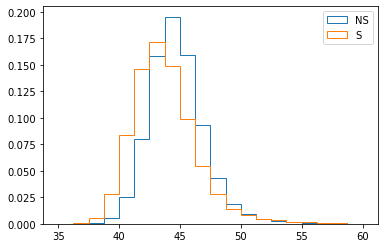

In [13]:
plt.hist(pwat6[:,-60:,:].values.ravel(),bins=20,range=(35,60),density=True,histtype='step')
plt.hist(pwat6[:,60:180,:].values.ravel(),bins=20,range=(35,60),density=True,histtype='step')
plt.legend(['NS','S'])

### Core cloudy updrafts

Text(0.5, 1.0, 'cloud core updrafts')

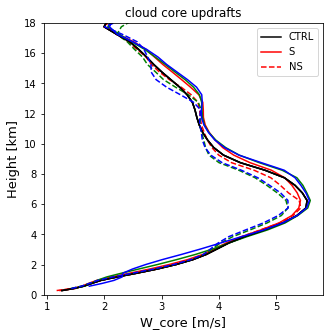

In [21]:
colors_tmp = ['r','g','b']
fig = plt.figure(figsize=(5,5))

for n,(w3d_exp,qc_exp,qi_exp) in enumerate(zip([w3d2,w3d4,w3d6],[qc2,qc4,qc6],[qi2,qi4,qi6])):
    w = w3d1[:,:,:,:].where(w3d1>1)
    w_ctrl = w.where(qc1+qi1>1e-5)

    w = w3d_exp[:,:,60:120,:].where(w3d_exp[:,:,60:120,:]>1)
    w_s = w.where((qc_exp+qi_exp)[:,:,60:120,:]>1e-5)
    w = w3d_exp[:,:,-60:,:].where(w3d_exp[:,:,-60:,:]>1)
    w_ns = w.where((qc_exp+qi_exp)[:,:,-60:,:]>1e-5)
    
    plt.plot(w_ctrl.mean(axis=(0,2,3)),w3d1.lev,'k')
    plt.plot(w_s.mean(axis=(0,2,3)),w3d1.lev,'-',color=colors_tmp[n])
    plt.plot(w_ns.mean(axis=(0,2,3)),w3d1.lev,'--',color=colors_tmp[n])
plt.ylim([0,18])
plt.xlabel('W_core [m/s]',fontsize=13)
plt.ylabel('Height [km]',fontsize=13)
plt.legend(['CTRL','S','NS'])
plt.title('cloud core updrafts')

In [31]:
-xr.concat([w3d_exp[0,:,-60:,:],w3d_exp[0,:,:60,:]],'lat')*prs_exp[0,:,-60:,0].mean(axis=1)*9.8

<xarray.DataArray (lev: 65, lat: 120, lon: 240)>
array([[[-6.38501172e+03,  6.63666504e+03,  2.01847578e+04, ...,
         -2.81355488e+04, -5.39262734e+04, -2.53011641e+04],
        [-3.50846055e+04, -1.50106650e+04,  3.29214492e+04, ...,
         -3.66008438e+04, -1.24474814e+04, -1.10238457e+04],
        [ 5.54497217e+03, -4.01863550e+03, -2.21579648e+04, ...,
         -2.59688926e+04,  6.68479346e+03,  1.30356465e+04],
        ...,
        [-5.01350439e+03,  8.77963965e+03, -2.10302246e+04, ...,
          1.79429961e+04,  3.76130547e+04, -6.26766943e+03],
        [-4.58129727e+04, -5.29330938e+04,  1.48316074e+04, ...,
          2.64800000e+04, -4.38369258e+04, -8.17886172e+04],
        [-5.04894727e+03,  2.06030547e+04, -3.66547578e+04, ...,
         -6.89217109e+04, -4.26484922e+04, -7.73033203e+03]],

       [[-1.83853262e+04,  2.63013984e+04,  7.21386406e+04, ...,
         -1.00456383e+05, -1.65133672e+05, -7.37741953e+04],
        [-1.14061148e+05, -4.45666094e+04,  1.04521242e+05, ...,
         -1.06997227e+05, -3.76896641e+04, -3.91057031e+04],
        [ 1.43296289e+04, -1.26580986e+04, -6.79277656e+04, ...,
         -7.86080469e+04,  1.89000879e+04,  3.70874805e+04],
...
         -1.84057556e+02,  4.20845070e+01,  3.09316162e+02],
        [ 3.64649597e+02,  1.77855453e+02, -2.73104801e+01, ...,
         -9.34242859e+01,  1.52422806e+02,  3.67993103e+02],
        [ 2.65064087e+02,  6.86603088e+01, -2.26903172e+01, ...,
          1.98620872e+01,  2.32949768e+02,  3.71662567e+02]],

       [[-9.07409134e+01,  1.28490667e+01,  8.32440262e+01, ...,
          1.37721603e+02, -4.34395638e+01, -1.29116348e+02],
        [-2.83037052e+01,  7.34696808e+01,  9.47932053e+01, ...,
          3.42077141e+01, -9.56753311e+01, -1.14048798e+02],
        [ 4.23143578e+01,  1.23305618e+02,  1.17142570e+02, ...,
         -1.13222198e+02, -1.41098099e+02, -7.77951584e+01],
        ...,
        [ 1.36039581e+02,  8.90587997e+01, -1.73409233e+01, ...,
         -7.76315155e+01, -3.38639188e+00,  8.83179169e+01],
        [ 1.15685539e+02,  5.99844589e+01, -1.18060064e+01, ...,
         -4.35084229e+01,  3.06361389e+01,  1.04400436e+02],
        [ 8.06827164e+01,  1.99752617e+01, -1.10411100e+01, ...,
          1.90323734e+00,  6.72937622e+01,  1.10918549e+02]]],
      dtype=float32)
Coordinates:
    time     object 0361-07-03 00:00:00
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 471.0 473.0 475.0 477.0 479.0
  * lev      (lev) float64 0.025 0.08684 0.1724 0.2816 ... 26.75 27.25 27.75
  * lat      (lat) float64 361.0 363.0 365.0 367.0 ... 113.0 115.0 117.0 119.0

In [28]:
colors_tmp = ['r','g','b']
fig = plt.figure(figsize=(5,5))

for n,(w3d_exp,prs_exp) in enumerate(zip([w3d2,w3d4,w3d6],[prs2,prs4,prs6])):
    omega = w3d1[:,:,:,:]*prs1[0,:,:,0].mean(axis=1)*9.8

    omega_s = -w3d_exp[:,:,60:120,:]*prs_exp[0,:,60:120,0].mean(axis=1)*9.8
    omega_ns = -xr.concat([w3d_exp[:,:,-60:,:],w3d_exp[:,:,:60,:]],dim='lat')*prs_exp[0,:,-60:,0].mean(axis=1)*9.8
    
    plt.plot(omega.mean(axis=(0,2,3)),prs_exp[0,:,:,0].mean(axis=1)/100,'k')
    plt.plot(omega_s.mean(axis=(0,2,3)),prs_exp[0,:,:,0].mean(axis=1)/100,'-',color=colors_tmp[n])
    plt.plot(omega_ns.mean(axis=(0,2,3)),prs_exp[0,:,:,0].mean(axis=1)/100,'--',color=colors_tmp[n])
plt.ylim([1000,100])
plt.xlabel('W [m/s]',fontsize=13)
plt.ylabel('Height [km]',fontsize=13)
plt.legend(['CTRL','S','NS'])
plt.title('cloud core updrafts')

ValueError: data_vars is not a valid argument when concatenating DataArray objects

<Figure size 360x360 with 0 Axes>

In [ ]:
dpwv_dt = np.nanmean(np.gradient(pwat6[:,60:180,:],20*3600,axis=0)*86400,axis=(1,2))
dprate_dt = np.nanmean(prate6[:,60:180,:],axis=(1,2))
plt.scatter(dpwv_dt,dprate_dt,color='r')

dpwv_dt = np.nanmean(np.gradient(pwat6[:,-60:,:],20*3600,axis=0)*86400,axis=(1,2))
dprate_dt = np.nanmean(prate6[:,-60:,:],axis=(1,2))
plt.scatter(dpwv_dt,dprate_dt)

In [ ]:
# cross-section of pwat and prate
#colors = ['moccasin','wheat','orange','darkorange','r','darkred']
colors = ['k','moccasin','wheat','orange','darkorange','r','b','orange','r']
linestyles = ['-','-','-','-','-','-',':',':',':']
markers = ['^','o','s']

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(7,6))
pwat_ctrl = pwat1[:,:,:].mean()
ax1.plot(y_dim,np.ones(len(y_dim))*pwat_ctrl.values,
              color='k')
m=0
for n,pwat in enumerate([pwat2,pwat3,pwat4,pwat5,pwat6,pwat7,pwat8,pwat9]):
    if n < 5:
        ax1.plot(y_dim,running_mean(pwat[:,:,:].mean(axis=(0,2)),5),
              color=colors[n+1],linestyle=linestyles[n+1])
    else:
        ax1.scatter(240,pwat[:,:,:].mean(),color='k',marker=markers[m],zorder=0)
        m+=1
    
prate_ctrl = prate1[:,:,:].mean()    
ax2.plot(y_dim,np.ones(len(y_dim))*prate_ctrl.values,
              color='k')
m=0
for n,prate in enumerate([prate2,prate3,prate4,prate5,prate6,prate7,prate8,prate9]):
    if n < 5:
        ax2.plot(y_dim,running_mean(prate[:,:,:].mean(axis=(0,2)),5),
              color=colors[n+1],linestyle=linestyles[n+1])
    else:
        ax2.scatter(240,prate[:,:,:].mean(),color='k',marker=markers[m],zorder=0)
        
ax1.legend(exp_short, ncol=2, fontsize=9,frameon=False)
    
ax1.set_ylabel('PW [mm]',fontsize=14)
ax2.set_ylabel('Precip [mm/d]',fontsize=14)
ax2.set_xlabel('y direction [km]',fontsize=14)
ax1.set_title('(a)',fontsize=15,loc='left')
ax2.set_title('(b)',fontsize=15,loc='left')

ax1.set_xlim([0,y_dim[-1]])
ax2.set_xlim([0,y_dim[-1]])
ax2.set_ylim([5,20])
ax1.set_xticks(np.linspace(0,480,9))
ax2.set_xticks(np.linspace(0,480,9))
ax1.grid(linestyle=':',linewidth=1)
ax2.grid(linestyle=':',linewidth=1)
plt.tight_layout()

fig.savefig(server+'fig_sum/pwat_prec_crossect_combined.pdf',bbox_inches='tight',transparent=False)

In [ ]:
# # pwat, precip boxplot
# fig,ax = plt.subplots(1,2,figsize=(12,5))

# pwat_all = [pwat1[-360:,:,:].mean().values.ravel(),pwat2[-360:,:,:].mean().values.ravel(),
#            pwat3[-360:,:,:].mean().values.ravel(),pwat4[-360:,:,:].mean().values.ravel(),
#            pwat5[-360:,:,:].mean().values.ravel()]

# ax[0].boxplot(pwat_all,labels=exp_short,showfliers=False);
# ax[0].set_ylim([43,48])
# ax[0].set_ylabel('PWV [mm]',fontsize=13)

# # pwat, precip boxplot
# prate_all = [prate1[-360:,:,:].mean().values.ravel(),prate2[-360:,:,:].mean().values.ravel(),
#              prate3[-360:,:,:].mean().values.ravel(),prate4[-360:,:,:].mean().values.ravel(),
#              prate5[-360:,:,:].mean().values.ravel()]

# ax[1].boxplot(prate_all,labels=exp_short,showfliers=False);
# ax[1].set_ylabel('PREC [mm/d]',fontsize=13)


In [ ]:
fig = plt.figure(figsize=(5,6))

tmp = (qv1)[-144:,:,:,0].mean(axis=(0,2))*1000

plt.plot(tmp-tmp,z_dim,'k')
plt.plot(1000*(qv2)[-144:,:,120:180,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot(1000*(qv3)[-144:,:,120:180,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot(1000*(qv4)[-144:,:,120:180,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot(1000*(qv5)[-144:,:,120:180,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot(1000*(qv6)[-144:,:,120:180,0].mean(axis=(0,2))-tmp,z_dim)

plt.legend(exp_short)
plt.title('RCE_EXP - RCE_CTRL')
plt.ylabel('Height [km]',fontsize=13)
plt.xlabel('$\Delta$qv [g/kg]',fontsize=13)
plt.ylim([0,12])

In [ ]:
fig = plt.figure(figsize=(5,6))

tmp = (th1)[-360:,:,:,0].mean(axis=(0,2))

plt.plot(tmp-tmp,z_dim)
plt.plot((th2)[-360:,:,:,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot((th3)[-360:,:,:,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot((th4)[-360:,:,:,0].mean(axis=(0,2))-tmp,z_dim)
plt.plot((th5)[-360:,:,:,0].mean(axis=(0,2))-tmp,z_dim)

plt.legend(exp_short)
plt.title('RCE_EXP - RCE_CTRL')
plt.ylabel('Height [km]',fontsize=13)
plt.xlabel('$\Delta$theta [K]',fontsize=13)
plt.ylim([0,20])

### Momentum cross-section 

In [ ]:
# # for jet experiments
# fig,ax = plt.subplots(3,1,figsize=(5,13))

# for n,(v3d,prs) in enumerate(zip([v3d2,v3d3,v3d4],[prs2,prs3,prs4])):
    
#     v3d_zmn = v3d.mean(axis=(0,3)) #[KJ/kg]
#     plev = prs[0,:,:,:].mean(axis=(1,2))
#     cf=ax[n].contourf(v3d.lat,prs.lev[:45],v3d_zmn[:45,:]-v3d_zmn[:45,:].mean(axis=1),cmap='bwr'
#                                   ,levels=np.linspace(-1,1,11))
#     ax[n].contour(v3d.lat,prs.lev[:45],v3d_zmn[:45,:]-v3d_zmn[:45,:].mean(axis=1),levels=np.linspace(-1,1,11)
#                                ,colors=['k'],linewidths=0.6)
#     ax[n].set_ylim([0,18])
#     cbar = plt.colorbar(cf,ax=ax[n],shrink=0.6)
#     cbar.set_label('V [m/s]')
#     ax[n].set_ylabel('height [km]',fontsize=13)
#     ax[n].set_xlabel('[km]',fontsize=13)
#     ax[n].set_title(exp_short[n+1],fontsize=13,loc='right')
        
# plt.tight_layout()
# fig.savefig(fig_dir+'/Vprofiles_jet_exps.pdf',bbox_inches='tight',transparent=False)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
row = [0,0,0,1,1,1]
col = [0,1,2,0,1,2]

for n,(v3d,prs) in enumerate(zip([v3d1,v3d2,v3d3,v3d4,v3d5,v3d6],[prs1,prs2,prs3,prs4,prs5,prs6])):
    
    v3d_zmn = v3d.mean(axis=(0,3)) #[KJ/kg]
    plev = prs[0,:,:,:].mean(axis=(1,2))
    cf=ax[row[n],col[n]].contourf(v3d.lat,plev[:45]/100,v3d_zmn[:45,:],cmap='bwr'
                                  ,levels=np.linspace(-1,1,11))
    ax[row[n],col[n]].contour(v3d.lat,plev[:45]/100,v3d_zmn[:45,:],levels=np.linspace(-1,1,11)
                               ,colors=['k'],linewidths=0.6)
    ax[row[n],col[n]].set_ylim([1000,100])
    cbar = plt.colorbar(cf,ax=ax[row[n],col[n]],shrink=0.6)
    cbar.set_label('V [m/s]')
    ax[row[n],col[n]].set_ylabel('[hPa]',fontsize=13)
    ax[row[n],col[n]].set_xlabel('[km]',fontsize=13)
    ax[row[n],col[n]].set_title(exp_short[n],fontsize=13,loc='right')
        
plt.tight_layout()
#fig.savefig(fig_dir+'/Vprofiles_all.pdf',bbox_inches='tight',transparent=False)

In [ ]:
plev[33]

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6))

for n,(v3d) in enumerate([v3d1,v3d2,v3d3,v3d4,v3d5,v3d6]):
    v3d_zmn = v3d.mean(axis=(0,3)) 
    ax1.plot(v3d.lat,v3d_zmn[5,:],'-',label=exp_short[n])
    ax2.plot(v3d.lat,v3d_zmn[33,:],'-',label=exp_short[n])
ax1.set_xlim([0,v3d.lat[-1]])
ax1.hlines(y=0,xmin=0,xmax=v3d.lat[-1],color='k',linewidth=1)
ax2.hlines(y=0,xmin=0,xmax=v3d.lat[-1],color='k',linewidth=1)
ax2.set_xlim([0,v3d.lat[-1]])
ax1.set_title('[V], at 950hPa',fontsize=13)
ax1.legend()
ax2.set_title('[V], at 200hPa',fontsize=13)
ax1.set_ylabel('[m/s]',fontsize=13)
ax2.set_ylabel('[m/s]',fontsize=13)
ax1.set_xlabel('[km]',fontsize=13)
ax2.set_xlabel('[km]',fontsize=13)

plt.tight_layout()

### MSE cross-section

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(15,6))
row = [0,0,0,1,1,1]
col = [0,1,2,0,1,2]

for n,(T,qv,v3d) in enumerate(zip([T1,T2,T3,T4,T5,T6],[qv1,qv2,qv3,qv4,qv5,qv6],[v3d1,v3d2,v3d3,v3d4,v3d5,v3d6])):
    mse = 1004*(T+273.15) + 9.8*T.lev*1000 + 2.5e6*qv
    mse_mn = mse.mean(axis=(0,3))/1000 #[KJ/kg]
    cf=ax[row[n],col[n]].contourf(T.lat,T.lev[:45],mse_mn[:45,:],cmap='jet'
                                  ,levels=np.linspace(324,350,14))
    ax[row[n],col[n]].contour(T.lat,T.lev[:45],mse_mn[:45,:],levels=np.linspace(324,380,14)
                              ,colors=['k'],linewidths=0.8)
    ax[row[n],col[n]].set_ylim([0,10])
    cbar = plt.colorbar(cf,ax=ax[row[n],col[n]],shrink=0.6)
    cbar.set_label('MSE [KJ/kg]')
    ax[row[n],col[n]].set_ylabel('Z [km]',fontsize=13)
    ax[row[n],col[n]].set_xlabel('[km]',fontsize=13)
    
    if n > 0:
        ins = ax[row[n],col[n]].inset_axes([0.8,0.15,0.2,0.85])
        ins.plot(mse_mn[:45,120],T.lev[:45],color='k')
        ins.plot(mse_mn[:45,50],T.lev[:45],linestyle='--',color='k')
        ins.set_ylim([0,10]);ins.set_yticks([])
        ins.legend(['S','NS'],fontsize=6)
        
        # v wind
        v_mn = v3d.mean(axis=(0,3)) # meridional wind [m/s]
        # set the key length
        lkey = 0.5
        # set the scale factor
        scalef = 0.01
        qu = ax[row[n],col[n]].quiver(v3d.lat[::10],v3d.lev[:45],v_mn[:45,::10],0*v_mn[:45,::10],
                                angles='xy',scale_units='xy',scale=scalef,pivot='mid')
        qu = ax[row[n],col[n]].quiverkey(qu,X=0.2,Y=1.05, U=lkey, label='quiver length='+str(lkey)+'(m/s)',
                                        labelpos='E',coordinates='axes')
        
plt.tight_layout()
#fig.savefig(fig_dir+'/MSEprofiles_all.pdf',bbox_inches='tight',transparent=False)

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(15,6))
row = [0,0,0,1,1,1]
col = [0,1,2,0,1,2]

for n,(T,qv,v3d) in enumerate(zip([T1,T2,T3,T4,T5,T6],[qv1,qv2,qv3,qv4,qv5,qv6],[v3d1,v3d2,v3d3,v3d4,v3d5,v3d6])):
    dse = 1004*(T+273.15) + 9.8*T.lev*1000 
    dse_mn = dse.mean(axis=(0,3))/1000 #[KJ/kg]
    cf=ax[row[n],col[n]].contourf(T.lat,T.lev[:45],dse_mn[:45,:],cmap='jet'
                                  ,levels=np.linspace(290,330,11))
    ax[row[n],col[n]].contour(T.lat,T.lev[:45],dse_mn[:45,:],levels=np.linspace(290,330,11)
                              ,colors=['k'],linewidths=0.8)
    ax[row[n],col[n]].set_ylim([0,10])
    cbar = plt.colorbar(cf,ax=ax[row[n],col[n]],shrink=0.6)
    cbar.set_label('DSE [KJ/kg]')
    ax[row[n],col[n]].set_ylabel('Z [km]',fontsize=13)
    ax[row[n],col[n]].set_xlabel('[km]',fontsize=13)
    
    if n > 0:
        ins = ax[row[n],col[n]].inset_axes([0.8,0.15,0.2,0.85])
        ins.plot(dse_mn[:45,120],T.lev[:45],color='k')
        ins.plot(dse_mn[:45,50],T.lev[:45],linestyle='--',color='k')
        ins.set_ylim([0,10]);ins.set_yticks([])
        ins.legend(['S','NS'],fontsize=6)
        
        # v wind
        v_mn = v3d.mean(axis=(0,3)) # meridional wind [m/s]
        # set the key length
        lkey = 0.5
        # set the scale factor
        scalef = 0.01
        qu = ax[row[n],col[n]].quiver(v3d.lat[::10],v3d.lev[:45],v_mn[:45,::10],0*v_mn[:45,::10],
                                angles='xy',scale_units='xy',scale=scalef,pivot='mid')
        qu = ax[row[n],col[n]].quiverkey(qu,X=0.2,Y=1.05, U=lkey, label='quiver length='+str(lkey)+'(m/s)',
                                        labelpos='E',coordinates='axes')
        
plt.tight_layout()a
#fig.savefig(fig_dir+'/MSEprofiles_all.pdf',bbox_inches='tight',transparent=False)

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(15,6))
row = [0,0,0,1,1,1]
col = [0,1,2,0,1,2]

for n,(qv,v3d) in enumerate(zip([qv1,qv2,qv3,qv4,qv5,qv6],[v3d1,v3d2,v3d3,v3d4,v3d5,v3d6])):
    
    qv_mn = qv.mean(axis=(0,3))
    
    cf=ax[row[n],col[n]].contourf(qv.lat,qv.lev[:45],1000*qv_mn[:45,:],cmap='terrain'
                                  ,levels=np.linspace(5,16,11))
    ax[row[n],col[n]].contour(qv.lat,qv.lev[:45],1000*qv_mn[:45,:],levels=np.linspace(5,16,11)
                              ,colors=['k'],linewidths=0.8)
    ax[row[n],col[n]].set_ylim([0,10])
    cbar = plt.colorbar(cf,ax=ax[row[n],col[n]],shrink=0.6)
    cbar.set_label('qv [g/kg]')
    ax[row[n],col[n]].set_ylabel('Z [km]',fontsize=13)
    ax[row[n],col[n]].set_xlabel('[km]',fontsize=13)
    
    if n > 0:
        ins = ax[row[n],col[n]].inset_axes([0.8,0.15,0.2,0.85])
        ins.plot(1000*qv_mn[:45,120],T.lev[:45],color='k')
        ins.plot(1000*qv_mn[:45,50],T.lev[:45],linestyle='--',color='k')
        ins.set_ylim([0,10]);ins.set_yticks([])
        ins.legend(['S','NS'],fontsize=6)
        
        # v wind
        v_mn = v3d.mean(axis=(0,3)) # meridional wind [m/s]
        # set the key length
        lkey = 0.5
        # set the scale factor
        scalef = 0.01
        qu = ax[row[n],col[n]].quiver(v3d.lat[::10],v3d.lev[:45],v_mn[:45,::10],0*v_mn[:45,::10],
                                angles='xy',scale_units='xy',scale=scalef,pivot='mid')
        qu = ax[row[n],col[n]].quiverkey(qu,X=0.2,Y=1.05, U=lkey, label='quiver length='+str(lkey)+'(m/s)',
                                        labelpos='E',coordinates='axes')
        
plt.tight_layout()
#fig.savefig(fig_dir+'/MSEprofiles_all.pdf',bbox_inches='tight',transparent=False)

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(15,9))
row = [0,0,0,1,1,1,2,2,2]
col = [0,1,2,0,1,2,0,1,2]

for n,rh in enumerate([rh1,rh2,rh3,rh4,rh5,rh6,rh7,rh8,rh9]):
    rh_mn = rh.mean(axis=(0,3))
    cf=ax[row[n],col[n]].contourf(rh.lat,rh.lev[:45],100*rh_mn[:45,:],cmap='terrain_r'
                                  ,levels=np.linspace(40,100,13))
    ax[row[n],col[n]].contour(rh.lat,rh.lev[:45],100*rh_mn[:45,:],levels=np.linspace(40,100,13)
                              ,colors=['k'],linewidths=0.8)
    ax[row[n],col[n]].set_ylim([0,18])
    cbar = plt.colorbar(cf,ax=ax[row[n],col[n]],shrink=0.6)
    cbar.set_label('RH [%]')
    ax[row[n],col[n]].set_ylabel('Z [km]',fontsize=13)
    ax[row[n],col[n]].set_xlabel('[km]',fontsize=13)
    
    # inside box 
    if n is 0 or n >= 6:
        ins = ax[row[n],col[n]].inset_axes([0.8,0.15,0.2,0.85])
        ins.plot(100*rh_mn[:45,:].mean(axis=1),rh.lev[:45],color='r')
        ins.set_xlim([55,100]);ins.set_xticks([55,75,95])
        ins.set_ylim([0,18]);ins.set_yticks([])
    else:
        ins = ax[row[n],col[n]].inset_axes([0.8,0.15,0.2,0.85])
        ins.plot(100*rh_mn[:45,120],rh.lev[:45],color='k')
        ins.plot(100*rh_mn[:45,50],rh.lev[:45],linestyle='--',color='k')
        ins.set_ylim([0,18]);ins.set_yticks([])
        ins.set_xlim([55,100]);ins.set_xticks([55,75,95])
        ins.legend(['S','NS'],fontsize=6)
    ax[row[n],col[n]].set_title(exp_short[n],loc='right')
plt.tight_layout()
fig.savefig(fig_dir+'/RHprofiles_all.pdf',bbox_inches='tight',transparent=False)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

for n,(cape,cin) in enumerate(zip([cape2,cape3,cape4,cape5,cape6],[cin2,cin3,cin4,cin5,cin6])):
    ax[0].plot(cape.lat,running_mean(cape.mean(axis=(0,2)),5),'-o')
    ax[1].plot(cin.lat,running_mean(cin.mean(axis=(0,2)),5),'-o')
ax[0].set_xlim([0,480])
ax[0].set_ylabel('CAPE [J/kg]',fontsize=13)
ax[0].set_xlabel('[km]',fontsize=13)
ax[0].grid(linestyle=':')
ax[0].legend(exp_short[1:7])

ax[1].set_xlim([0,480])
ax[1].set_ylabel('CIN [J/kg]',fontsize=13)
ax[1].set_xlabel('[km]',fontsize=13)
ax[1].grid(linestyle=':')
fig.savefig(fig_dir+'/cape_cin_all.pdf',bbox_inches='tight',transparent=False)

### MSE transport across domain

In [ ]:
# take U15 as the first example... update functions later 
os.chdir('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU15')
t_start = 360; t_end = 721
file_name = glob('*nc')
data_zon = xr.open_dataset('cm1out_zonmean.nc')
data_3d = xr.open_dataset('cm1out_sub3d.nc')
data_2d = xr.open_dataset('cm1out_2Dvars.nc')

u3d = data_3d.uinterp[t_start:t_end,:,:,:]
v3d = data_3d.vinterp[t_start:t_end,:,:,:]
w3d = data_3d.winterp[t_start:t_end,:,:,:]
th3d = data_3d.th[t_start:t_end,:,:,:]
qv3d = data_3d.qv[t_start:t_end,:,:,:]

# zonal mean data
th = data_zon.th[t_start:t_end,:,:,:]
qv = data_zon.qv[t_start:t_end,:,:,:]
#u = data_zon.uinterp[t_start:t_end,:,:,:]
#v = data_zon.vinterp[t_start:t_end,:,:,:]
#w = data_zon.winterp[t_start:t_end,:,:,:]
qc = data_zon.qc[t_start:t_end,:,:,:]
qi = data_zon.qi[t_start:t_end,:,:,:]
prs = data_zon.prs[t_start:t_end,:,:,:]

# for prs 3d 
prs_ref = prs[0,:,:,0].mean('lat').values
prs_3d = np.tile(prs_ref,(len(u3d.time),len(u3d.lat),len(u3d.lon),1)).swapaxes(1,3)
prs_3d_xr = xr.DataArray(prs_3d, coords=[prs.time,data_3d.lev,data_3d.lat,data_3d.lon],dims=['time','lev','lat','lon'])

# 2d data
prate = data_2d.prate[t_start:t_end,:,:]
pwat = data_2d.pwat[t_start:t_end,:,:]
cwp = data_2d.cwp[t_start:t_end,:,:]
cape = data_2d.cape[t_start:t_end,:,:]
cin = data_2d.cin[t_start:t_end,:,:]

# temperature conversion
T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
T3d = th3d/((1000*100/prs_3d_xr)**(287.15/1004))-273.15 # [degC]

In [ ]:
# density 
ro3d = prs_3d_xr/(287.15*(T3d+273.15))

In [ ]:
omega_test = -ro3d[-144:,:,:,:]*9.8*w3d[-144:,:,:,:]
omega_test = omega_test.mean(('time','lon'))

fig,ax = plt.subplots(1,1,figsize=(10,3))
cf = ax.contourf(omega_test.lat,prs_3d_xr[0,:,0,0]/100,omega_test,cmap='bwr')
ax2 = ax.twinx()
ax2.plot(omega_test.lat,24*3600*prate[-144:,:].mean(('time','lon')),'k')
ax.set_ylim([1000,100])
plt.colorbar(cf,pad=0.05)

In [ ]:
### vint_del_hv
tt=144

#mse3d = 1004*(T3d[-tt:,:,:,:]+273.15) + 9.8*T3d[-tt:,:,:,:].lev*1000 + 2.5e6*qv3d[-tt:,:,:,:]
mse3d = 2.5e6*qv3d[-tt:,:,:,:]

h_hadv = v3d[-tt:,:,:,:]*np.gradient(mse3d,mse3d.lat*1000,axis=2) + u3d[-tt:,:,:,:]*np.gradient(mse3d,mse3d.lon*1000,axis=3)
h_vadv = (-ro3d[-tt:,:,:,:]*9.8*w3d[-tt:,:,:,:])*np.gradient(mse3d,prs_3d_xr[0,:,0,0],axis=1)
del_hv = h_hadv + h_vadv
vint_del_hv = -1/9.8*np.trapz(del_hv,prs_3d_xr[0,:,0,0],axis=1)

In [ ]:
### vint_del_hv in lower troposphere below 3km
tt=144
#mse3d = 1004*(T3d[-tt:,:,:,:]+273.15) + 9.8*T3d[-tt:,:,:,:].lev*1000 + 2.5e6*qv3d[-tt:,:,:,:]
mse3d = 2.5e6*qv3d[-tt:,:,:,:]

h_hadv = v3d[-tt:,:,:,:]*np.gradient(mse3d,mse3d.lat*1000,axis=2) + u3d[-tt:,:,:,:]*np.gradient(mse3d,mse3d.lon*1000,axis=3)
h_vadv = (-ro3d[-tt:,:,:,:]*9.8*w3d[-tt:,:,:,:])*np.gradient(mse3d,prs_3d_xr[0,:,0,0],axis=1)
del_hv_LT = h_hadv[:,:20,:,:] + h_vadv[:,:20,:,:]
del_hv_RT = h_hadv[:,20:,:,:] + h_vadv[:,20:,:,:]
vint_del_hv_LT = -1/9.8*np.trapz(del_hv_LT,prs_3d_xr[0,:20,0,0],axis=1)

vint_del_hv_RT = -1/9.8*np.trapz(del_hv_RT,prs_3d_xr[0,20:,0,0],axis=1)
vint_del_hv_tot = vint_del_hv_LT + vint_del_hv_RT

In [ ]:
omega_test = -ro3d[-144:,:,:,:]*9.8*w3d[-144:,:,:,:]
omega_test = omega_test.mean(('time','lon'))

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,6))

cf = ax[0].contourf(omega_test.lat,prs_3d_xr[0,:,0,0]/100,omega_test,cmap='bwr')
ax2 = ax[0].twinx()
ax2.plot(omega_test.lat,24*3600*prate[-144:,:].mean(('time','lon')),'k')
ax2.set_ylabel('P [mm/d]')
ax[0].set_ylabel('[hPa]')
ax[0].set_ylim([1000,100])
ax[0].set_xlim([0,480])

cax = fig.add_axes([0.95,0.56,0.01,0.3])
cbar = plt.colorbar(cf,cax)
cbar.set_label('[Pa/s]')

ax[1].plot(v3d.lat,-vint_del_hv.mean(axis=(0,2))) # moisture flux convergence
ax[1].plot(v3d.lat,running_mean(-vint_del_hv_LT.mean(axis=(0,2)),5),'r')
ax[1].plot(v3d.lat,running_mean(-vint_del_hv_RT.mean(axis=(0,2)),5),'b')
ax[1].plot(v3d.lat,running_mean(-vint_del_hv_tot.mean(axis=(0,2)),5),'k')
ax[1].plot(v3d.lat,np.ones(len(data_2d.lat))*-vint_del_hv.mean(),'grey')
ax[1].set_xlim([0,480])
ax[1].set_ylabel('[W/m$^2$]')
ax[1].set_title(r'integrated qv flux convergence, <$\nabla$(vh)>')
#fig.savefig(fig_dir+'/omega_p_qvflux_section_U05.pdf',bbox_inches='tight',transparent=False)

In [ ]:
from scipy.stats import linregress

In [ ]:
# scatter plot 
p_diff = 2.5e6*prate[-144:,:].mean(('time','lon')) - 12.3/86400*2.5e6
plt.scatter(-running_mean(vint_del_hv.mean(axis=(0,2)),5),running_mean(p_diff,5),color='k')
slp,interp,r_val,p_val,stderr = linregress(-running_mean(vint_del_hv.mean(axis=(0,2)),5),running_mean(p_diff,5))
         
x = np.linspace(-200,200,100)
y = x*slp+interp
plt.plot(x,y,'r')    
plt.xlim([-100,100])
plt.ylim([-150,150])
plt.xlabel(r'$\nabla$<qv> [W/m$^2$]',fontsize=12)
plt.ylabel(r'LP [W/m$^2$]',fontsize=12)
plt.grid()

In [ ]:
slp

In [ ]:
plt.plot(-vint_del_hv_LT.mean(axis=(0,2))) # moisture flux convergence
plt.plot(running_mean(-vint_del_hv_LT.mean(axis=(0,2)),5),'k')
plt.plot(np.ones(len(data_2d.lat))*-vint_del_hv_LT.mean())

### Precipitaiton Efficiency 

In [ ]:
def LSPE2_calc(exp_dir,t_sampling=144):
    os.chdir('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'+exp_dir)
    
    data = xr.open_dataset('cm1out_sub3d.nc')
    u = data.uinterp[-t_sampling:,:,:]
    v = data.vinterp[-t_sampling:,:,:]
    w = data.winterp[-t_sampling:,:,:]
    qv = data.qv[-t_sampling:,:,:]
    
    data = xr.open_dataset('cm1out_q3d.nc')
    qc = data.qc[-t_sampling:,:,:]
    qi = data.qi[-t_sampling:,:,:]
#    qr = data.qr[-t_sampling:,:,:]
#    qs = data.qs[-t_sampling:,:,:]
#    qg = data.qg[-t_sampling:,:,:]

    data2 = xr.open_dataset('cm1out_2Dvars.nc')
    prate = data2.prate
    prate = prate[-t_sampling:,:,:] # kg/m^2/s
    
    try:
        data3 = xr.open_dataset('cm1out_SFX.nc')
        qfx = data3.qfx[-t_sampling:,:,:].values # kg/m^2/s
    except:
        qfx = np.ones(prate.shape)*1.41203e-4

    # ----------------------------------------
    z_dim = qv.lev*1000
    
    ro = ro1[-t_sampling:,:,0,0]
    ro = np.tile(ro,(qv.shape[2],qv.shape[1],1,1))
    ro = ro.swapaxes(0,2)
    ro = ro.swapaxes(1,3) # air density kg/m^3

    # calculate large-scale precipitaiton efficiency (LSPE2), Sui et al., 2007
    # all units are kg/m^2/s
    tmp = np.trapz(ro*qv,z_dim,axis=1)
    Q_wvt = -np.gradient(tmp,20*60,axis=0) # local tendency of vertically-integrated water vapor, - d[qv]/dt

    tmp = -(np.gradient(qv*u,2000,axis=3) + np.gradient(qv*v,2000,axis=2)) # vertically-integrated moisture flux convergence -div(qv*u)
    Q_wvf = np.trapz(ro*tmp,z_dim,axis=1) 

    Q_wve = qfx # surface evaporation rate 

    c1 = qc + qi #qr + qi + qs + qg # hydrometeors 
    tmp = -(np.gradient(c1*u,2000,axis=3) + np.gradient(c1*v,2000,axis=2)) 
    conv_c = np.trapz(ro*tmp,z_dim,axis=1) # vertically-integrated conv_c

    tmp = np.trapz(ro*c1,z_dim,axis=1)
    Q_cm = -np.gradient(tmp,20*60,axis=0) + conv_c # -d[c]/dt + [conv_c]

    Ps = Q_wvt + Q_wvf + Q_wve + Q_cm

    # set zero if values are negative (not sources for P)
    Q_wvt[Q_wvt<0] = 0
    Q_wvf[Q_wvf<0] = 0
    Q_wve[Q_wve<0] = 0
    Q_cm[Q_cm<0] = 0

    LSPE2 = prate.values/(Q_wvt + Q_wvf + Q_wve + Q_cm)

    return LSPE2, prate

In [ ]:
os.chdir('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240_int/')
data = xr.open_dataset('cm1out_hydro3d.nc')
u = data.uinterp
v = data.vinterp
w = data.winterp
qv = data.qv
qc = data.qc
qi = data.qi
qr = data.qr
qs = data.qs
qg = data.qg

data2 = xr.open_dataset('cm1out_2Dvars.nc')
pwat = data2.pwat
pwat = pwat[-145:,:,:]
prate = data2.prate
prate = prate[-145:,:,:] # kg/m^2/s

data3 = xr.open_dataset('cm1out_qvbgt.nc')
qv_cnd = data3.qt_cond
qv_dep = data3.qt_dep

In [ ]:
z_dim = qv.lev*1000

In [ ]:
test,prate = LSPE2_calc(exp_name[4],t_sampling=360)
tmp = 3600*prate.values # [mm/h]
test[test<=0] = np.nan
test[tmp<=0] = np.nan # only precipitating grids
plt.plot(100*np.nanmean(test,axis=(0,2)))

In [ ]:
test,prate = LSPE2_calc(exp_name[2],t_sampling=360)
tmp = 3600*prate.values # [mm/h]
test[test<=0] = np.nan
test[tmp<=0] = np.nan # only precipitating grids
plt.plot(100*np.nanmean(test,axis=(0,2)))

In [ ]:
test,rain = LSPE2_calc(exp_name[0],t_sampling=360)
tmp = 3600*rain.values # [mm/h]
test[test<=0] = np.nan
test[tmp<=0] = np.nan # only precipitating grids

LSPE2_CTRL = np.tile(test,(1,2))
plt.plot(running_mean(np.nanmean(test,axis=(0,2)),5))

In [ ]:
fig = plt.figure(figsize=(8,4))
colors = ['k','r','g','b','darkred']
LSPE2_mean = np.empty((len(exp_name),len(y_dim)))

for n,exp in enumerate(exp_name[1:]):
    print(exp)
    test,rain = LSPE2_calc(exp,t_sampling=360)
    tmp = 3600*rain.values # [mm/h]
    test[test<=0] = np.nan
    test[tmp<=0] = np.nan # only precipitating grids
    
    LSPE2_mean[n,:] = 100*np.nanmean(test,axis=(0,2))

In [ ]:
LSPE2_CTRL.shape

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4),gridspec_kw={'width_ratios': [3, 1]})

for n,exp in enumerate(exp_name[1:]):

    ax[0].plot(y_dim,running_mean(LSPE2_mean[n,:],5),color=colors[n],label=exp)
    ax[0].set_ylabel('LSPE [%]',fontsize=13)
    ax[0].set_xlabel('y dimension [km]',fontsize=13)
    
    # area-mean 
    LSPE2_ns = np.mean(np.concatenate([LSPE2_mean[n,:60],LSPE2_mean[n,-60:]]),axis=0)
    LSPE2_ns_std = np.std(np.concatenate([LSPE2_mean[n,:60],LSPE2_mean[n,-60:]]),axis=0)
    LSPE2_s = np.mean(LSPE2_mean[n,60:180],axis=0)
    LSPE2_s_std = np.std(LSPE2_mean[n,60:180],axis=0)

    ax[1].plot(1,LSPE2_ns,'o',color=colors[n],markersize=8)
    ax[1].plot(2,LSPE2_s,'x',color=colors[n],markersize=8)

# add CTRL, no shear    
ax[0].plot(y_dim,100*np.nanmean(LSPE2_CTRL,axis=(0,1)),color='grey',label=exp_name[0])
    
ax[0].set_xlim([0,480])    
ax[0].set_ylim([5,45])
ax[0].legend()
ax[1].set_xlim([0,3])
ax[1].set_xticks([0,1,2,3])
ax[1].set_xticklabels(['','Non-Shear','Shear ','']);

plt.plot()

fig.savefig('../fig_analysis/LSPE2_combined.pdf',bbox_inches='tight',transparent=False)

In [ ]:
def vint_mositure_conv(exp_dir, t_sampling=360):
    "calculate moisture flux convergence [t,x,y]"
    os.chdir('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'+exp_dir)
    data = xr.open_dataset('cm1out_sub3d.nc')
    u = data.uinterp[-t_sampling:,:,:,:]
    v = data.vinterp[-t_sampling:,:,:,:]
    w = data.winterp[-t_sampling:,:,:,:]
    qv = data.qv[-t_sampling:,:,:,:]
    th = data.th[-t_sampling:,:,:,:]
    
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    prs = data_zon.prs[-t_sampling,:,:]
    prs = np.tile(prs,(1,120))
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))
 
    # moisture flux convergence 
    tmp = -(np.gradient(qv*u,2000,axis=3) + np.gradient(qv*v,2000,axis=2)) # vertically-integrated moisture flux convergence -div(qv*u)
    moist_conv = np.trapz(ro*tmp,z_dim,axis=1) 
    
    return moist_conv

In [ ]:
exp_name[1:]

In [ ]:
fig = plt.figure(figsize=(8,4))
colors = ['k','r','g','b','darkred']
linestyles= ['-','-','-','-','-','--','--','--']

for n,exp in enumerate(exp_name[1:]):
    moist_conv = vint_mositure_conv(exp,t_sampling=360)

    plt.plot(qv.lat,running_mean(np.nanmean(moist_conv,axis=(0,2)),5),color=colors[n],label=exp)
    plt.hlines(0,xmin=qv.lat[0],xmax=qv.lat[-1],linewidth=1)
    plt.ylabel('Moisture Conv. [kg/m$^2$/s]',fontsize=13)
    plt.xlabel('y dimension [km]',fontsize=13)
    plt.xlim([qv.lat[0],qv.lat[-1]])
    plt.legend()

In [ ]:
fig.savefig('../fig_analysis/moisture_conv_combined.pdf',bbox_inches='tight',transparent=False)

In [ ]:
# focusing on precipitiaton? 
# more precipitating grids or more extremes accounting for stronger rainfall in sheared regime
# precipitation density distribution

pgrids_counts = np.empty((8,240))

for n,rain in enumerate([prate1,prate2,prate3,prate4,prate5,prate6,prate7,prate8]):
    tmp = np.reshape(rain[-360:,:,:].values.swapaxes(1,2),(360*120,240))
    tmp[tmp>0] = 1 
    pgrids_counts[n,:] = np.sum(tmp,axis=0)

In [ ]:
fig = plt.figure(figsize=(8,4))

for n in range(8):
    plt.plot(pgrids_counts[n,:]/360,color=colors[n],linestyle=linestyles[n],
             label=exp_name[n])
plt.legend()
plt.xlim([0,240])
plt.xlabel('y dimension [km]',fontsize=13)
plt.ylabel('Precipitating grids [#]',fontsize=13)

In [ ]:
# precipitation probabiltiy

prec_bins = np.linspace(0,120,61)
prec_prob_com = np.empty((5,2,len(prec_bins)-1))

for n,rain in enumerate([prate1,prate2,prate3,prate4,prate5]):
    tmp = 1/24*np.reshape(rain[-360:,:,:].values.swapaxes(1,2),(360*120,240)) # rainfall [mm/h]
    rain_ns = np.concatenate([tmp[:,:40],tmp[:,-40:]]) # non-shear regime
    rain_s = tmp[:,90:170] # shear regime
    
    for i in range(len(prec_bins)-1):
        idx_ns = np.where(np.logical_and(rain_ns.ravel()>=prec_bins[i]
                                      ,rain_ns.ravel()<prec_bins[i+1]))[0]
        idx_s = np.where(np.logical_and(rain_s.ravel()>=prec_bins[i]
                                      ,rain_s.ravel()<prec_bins[i+1]))[0]
        prec_prob_com[n,0,i] = len(idx_ns) 
        prec_prob_com[n,1,i] = len(idx_s)

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

for n in range(5):
    ax[n].plot(prec_bins[:-1],prec_prob_com[n,0,:]/np.sum(prec_prob_com[n,0,:]),'k',label='NS')
    ax[n].plot(prec_bins[:-1],prec_prob_com[n,1,:]/np.sum(prec_prob_com[n,1,:]),'r',label='S')
    
    # adding reference CTRL probability
    ax[n].plot(prec_bins[:-1],prec_prob_com[0,0,:]/np.sum(prec_prob_com[0,0,:]),
                                        'grey',linestyle='--',label='REF')
    
    # adding refeernce UNIshear probability
#     if n == 1:
#         ax[n].plot(prec_bins[:-1],prec_prob_com[5,0,:]/np.sum(prec_prob_com[5,0,:]),
#                                         'grey',linestyle='--',label='UNI')
#     if n == 2:
#         ax[n].plot(prec_bins[:-1],prec_prob_com[6,0,:]/np.sum(prec_prob_com[6,0,:]),
#                                         'grey',linestyle='--',label='UNI')
#     if n == 3:
#         ax[n].plot(prec_bins[:-1],prec_prob_com[6,0,:]/np.sum(prec_prob_com[6,0,:]),
#                                         'grey',linestyle='--',label='UNI')
    
    ax[n].set_xlabel('Rain rate [mm/h]')
    ax[n].set_ylabel('Probability')
    ax[n].set_yscale('log')
    ax[n].set_ylim([1e-6,1e-1])
    ax[n].legend()
    ax[n].set_title(exp_short[n],fontsize=13)

### sounding profiles

In [ ]:
# mse profile at shear and non-shear regimes
mse_profile = np.empty((len(exp_name),2,len(z_dim)))
cp = 1004
Lv = 2.5e6

for n,(T,qv) in enumerate(zip([T1,T2,T3,T4,T5,T6,T7],[qv1,qv2,qv3,qv4,qv5,qv6,qv7])):
    mse_p = np.mean(cp*(T+273.15)+Lv*qv+9.8*z_dim*1000,axis=0).squeeze()
    mse_profile[n,0,:] = mse_p[:,60:180].mean(axis=1)
    mse_profile[n,1,:] = np.concatenate([mse_p[:,:60],mse_p[:,-60:]],axis=1).mean(axis=1)

In [ ]:
fig = plt.figure(figsize=(5,6))
for n in range(4):
    plt.plot(running_mean(mse_profile[n,0,:]/1000-mse_profile[0,0,:]/1000,3),z_dim,label=exp_short[n]
            ,linestyle=linestyles[n],color=colors[n])
    plt.plot(running_mean(mse_profile[n,1,:]/1000-mse_profile[0,0,:]/1000,3),z_dim,label=exp_short[n]
            ,linestyle='--',color=colors[n])
plt.legend()
plt.ylim([0,18])
#plt.xlim([325,345])

### Budget analysis for regimes of different organization

In [ ]:
def TwoRegime_profile(data):
    data_s = np.mean(data[:,90:170],axis=1)
    data_ns = np.mean(np.concatenate([data[:,:40],data[:,-40:]],axis=1),axis=1)
    return data_s, data_ns

In [ ]:
exp_name = ['CM1_RAD4K_OPENMP_CTRL_RCEP_120x240',
            'CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240',
            'CM1_RAD4K_OPENMP_Midjet_RCEP_120x240',
            'CM1_RAD4K_OPENMP_Highjet_RCEP_120x240']

In [ ]:
data = xr.open_dataset('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'+exp_name[0]+
                       '/cm1out_qvbgt.nc')
z_dim = data.lev

In [ ]:
# water vapor budget chnages in y-direction
qvb_hadv_com = np.empty((len(exp_name),2,len(z_dim)))
qvb_vadv_com = np.empty((len(exp_name),2,len(z_dim)))
qvb_hturb_com = np.empty((len(exp_name),2,len(z_dim)))
qvb_vturb_com = np.empty((len(exp_name),2,len(z_dim)))
qvb_mp_com = np.empty((len(exp_name),2,len(z_dim)))

qvb_hadv_dm = np.empty((len(exp_name),len(z_dim)))
qvb_vadv_dm = np.empty((len(exp_name),len(z_dim)))
qvb_hturb_dm = np.empty((len(exp_name),len(z_dim)))
qvb_vturb_dm = np.empty((len(exp_name),len(z_dim)))
qvb_mp_dm = np.empty((len(exp_name),len(z_dim)))

for n in range(len(exp_name)):
    data = xr.open_dataset('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'+exp_name[n]+
                          '/cm1out_qvbgt.nc')
    qvb_hadv = data.qvb_hadv[-360:,:,:,:]        # horizontal advection
    qvb_vadv = data.qvb_vadv[-360:,:,:,:]      # vertical advection
    qvb_hturb = data.qvb_hturb[-360:,:,:,:]    # horizontal turbulence tendency
    qvb_vturb = data.qvb_vturb[-360:,:,:,:]    # vertical turbulence tendency
    qvb_mp = data.qvb_mp[-360:,:,:,:]          # tendency from microphysical scheme
    #qvb_pbl = data.qvb_pbl[-360:,:,:,:]        # tendency from PBL scheme
    
    # Domain average
    qvb_hadv_dm[n,:] = qvb_hadv.mean(axis=(0,2,3))
    qvb_vadv_dm[n,:] = qvb_vadv.mean(axis=(0,2,3))
    qvb_hturb_dm[n,:] = qvb_hturb.mean(axis=(0,2,3))
    qvb_vturb_dm[n,:] = qvb_vturb.mean(axis=(0,2,3))
    qvb_mp_dm[n,:] = qvb_mp.mean(axis=(0,2,3))    
    
    # y-direction
    qvb_hadv_yz = np.nanmean(qvb_hadv,axis=(0,3)) # (z,y)
    qvb_vadv_yz = np.nanmean(qvb_vadv,axis=(0,3))
    qvb_hturb_yz = np.nanmean(qvb_hturb,axis=(0,3))
    qvb_vturb_yz = np.nanmean(qvb_vturb,axis=(0,3))
    qvb_mp_yz = np.nanmean(qvb_mp,axis=(0,3))
    #qvb_pbl_yz = np.nanmean(qvb_pbl_yz,axis=(0,3))
    
    del qvb_hadv,qvb_vadv,qvb_hturb,qvb_vturb,qvb_mp
    
    # splitting shear and nonshear, vertical profile output
    qvb_hadv_s, qvb_hdv_ns = TwoRegime_profile(qvb_hadv_yz)
    qvb_vadv_s, qvb_vadv_ns = TwoRegime_profile(qvb_vadv_yz)
    qvb_hturb_s, qvb_hturb_ns = TwoRegime_profile(qvb_hturb_yz)
    qvb_vturb_s, qvb_vturb_ns = TwoRegime_profile(qvb_vturb_yz)
    qvb_mp_s, qvb_mp_ns = TwoRegime_profile(qvb_mp_yz)

    qvb_hadv_com[n,:,:] = qvb_hadv_s, qvb_hdv_ns
    qvb_vadv_com[n,:,:] = qvb_vadv_s, qvb_vadv_ns 
    qvb_hturb_com[n,:,:] = qvb_hturb_s, qvb_hturb_ns
    qvb_vturb_com[n,:,:] = qvb_vturb_s, qvb_vturb_ns
    qvb_mp_com[n,:,:] = qvb_mp_s, qvb_mp_ns

In [ ]:
exp_name

In [ ]:
# plot section
fig,ax = plt.subplots(1,5,figsize=(20,5))
for n in range(len(exp_name)):
    ax[0].plot(running_mean(qvb_hadv_dm[n,:]-qvb_hadv_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[1].plot(running_mean(qvb_vadv_dm[n,:]-qvb_vadv_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[2].plot(running_mean(qvb_hturb_dm[n,:]-qvb_hturb_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[3].plot(running_mean(qvb_vturb_dm[n,:]-qvb_vturb_dm[0,:],3),z_dim,color=colors[n],linestyle='-')

    ax[4].plot(running_mean(qvb_mp_dm[n,:]-qvb_mp_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[n].set_xlabel('[kg/kg/s]',fontsize=13)
    ax[n].set_ylabel('[km]',fontsize=13)
    
ax[0].set_title('QV_HADV, diff');ax[0].set_ylim([0,10])
ax[1].set_title('QV_VADV, diff');ax[1].set_ylim([0,10])
ax[2].set_title('QV_HTURB, diff');ax[2].set_ylim([0,10])
ax[3].set_title('QV_VTURB, diff');ax[3].set_ylim([0,10])
ax[4].set_title('QV_MPHYSICS, diff');ax[4].set_ylim([0,10])
ax[4].set_xlabel('[kg/kg/s]',fontsize=13)
ax[4].set_ylabel('[km]',fontsize=13)

In [ ]:
# theta tendency
# water vapor budget chnages in y-direction
ptb_hadv_dm = np.empty((len(exp_name),len(z_dim)))
ptb_vadv_dm = np.empty((len(exp_name),len(z_dim)))
ptb_hturb_dm = np.empty((len(exp_name),len(z_dim)))
ptb_vturb_dm = np.empty((len(exp_name),len(z_dim)))
ptb_rdamp_dm = np.empty((len(exp_name),len(z_dim)))
ptb_mp_dm = np.empty((len(exp_name),len(z_dim)))
tt_cond_dm = np.empty((len(exp_name),len(z_dim)))
tt_evac_dm = np.empty((len(exp_name),len(z_dim)))
tt_evar_dm = np.empty((len(exp_name),len(z_dim)))

for n in range(len(exp_name)):
    data = xr.open_dataset('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'+exp_name[n]+
                          '/cm1out_thbgt.nc')
    ptb_hadv = data.ptb_hadv[-144:,:,:,:]        # horizontal advection
    ptb_vadv = data.ptb_vadv[-144:,:,:,:]      # vertical advection
    ptb_hturb = data.ptb_hturb[-144:,:,:,:]    # horizontal turbulence tendency
    ptb_vturb = data.ptb_vturb[-144:,:,:,:]    # vertical turbulence tendency
    ptb_mp = data.ptb_mp[-144:,:,:,:]          # tendency from microphysical scheme
    ptb_rdamp = data.ptb_rdamp[-144:,:,:,:]        # tendency from PBL scheme
    tt_cond = data.tt_cond[-144:,:,:,:]        # condensation
    tt_evac = data.tt_evac[-144:,:,:,:]        # evaporation from cloud
    tt_evar = data.tt_evar[-144:,:,:,:]        # evporation from rain

    ptb_hadv_dm[n,:] = np.nanmean(ptb_hadv,axis=(0,2,3))
    ptb_vadv_dm[n,:] = np.nanmean(ptb_vadv,axis=(0,2,3))
    ptb_hturb_dm[n,:] = np.nanmean(ptb_hturb,axis=(0,2,3))
    ptb_vturb_dm[n,:] = np.nanmean(ptb_vturb,axis=(0,2,3))
    ptb_rdamp_dm[n,:] = np.nanmean(ptb_rdamp,axis=(0,2,3))
    ptb_mp_dm[n,:] = np.nanmean(ptb_mp,axis=(0,2,3))
    tt_cond_dm[n,:] = np.nanmean(tt_cond,axis=(0,2,3))
    tt_evac_dm[n,:] = np.nanmean(tt_evac,axis=(0,2,3))
    tt_evar_dm[n,:] = np.nanmean(tt_evar,axis=(0,2,3))

In [ ]:
# plot section
fig,ax = plt.subplots(1,5,figsize=(20,5))
for n in range(len(exp_name)):
    ax[0].plot(running_mean(ptb_hadv_dm[n,:]-ptb_hadv_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[1].plot(running_mean(ptb_vadv_dm[n,:]-ptb_vadv_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[2].plot(running_mean(ptb_rdamp_dm[n,:]-ptb_rdamp_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[3].plot(running_mean(ptb_vturb_dm[n,:]-ptb_vturb_dm[0,:],3),z_dim,color=colors[n],linestyle='-')

    ax[4].plot(running_mean(ptb_mp_dm[n,:]-ptb_mp_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
#    ax[4].plot(running_mean(qvb_mp_dm[n,:]-qvb_mp_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
#    ax[4].plot(running_mean(qvb_mp_dm[n,:]-qvb_mp_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
#    ax[4].plot(running_mean(qvb_mp_dm[n,:]-qvb_mp_dm[0,:],3),z_dim,color=colors[n],linestyle='-')
    
    ax[n].set_xlabel('[K/s]',fontsize=13)
    ax[n].set_ylabel('[km]',fontsize=13)
    
ax[0].set_title('TH_HADV, diff');ax[0].set_ylim([0,10])
ax[1].set_title('TH_VADV, diff');ax[1].set_ylim([0,10])
ax[2].set_title('TH_RDMAP, diff');ax[2].set_ylim([0,10])
ax[3].set_title('TH_VTURB, diff');ax[3].set_ylim([0,10])
ax[4].set_title('TH_MPHYSICS, diff');ax[4].set_ylim([0,10])
ax[4].set_xlabel('[kg/kg/s]',fontsize=13)
ax[4].set_ylabel('[km]',fontsize=13)